# TEAM CHALLENGE **PIPELINES**

Voy a empezar con los datos del dataset de **Nutrición**

## Problema de negocio y tareas

**Problema de clasificación**: Predecir qué tipo de alimento es dadas a una serie de características.  
**Problema de regresión**: Predecir cuántas kcal tiene un alimento dependiendo de unas variables

## Importación de módulos

In [85]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import toolbox_ML as tb
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#De la libreria de imbalanced-learn:

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import EditedNearestNeighbours, RandomUnderSampler
from imblearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as ImbPipeline




## Carga de datos y primera visualización

In [2]:
df = pd.read_csv('./data/nutrition.csv')
df.head()

,ID,FoodGroup,ShortDescrip,Descrip,CommonName,MfgName,ScientificName,Energy_kcal,Protein_g,Fat_g,...,Folate_USRDA,Niacin_USRDA,Riboflavin_USRDA,Thiamin_USRDA,Calcium_USRDA,Copper_USRDA,Magnesium_USRDA,Phosphorus_USRDA,Selenium_USRDA,Zinc_USRDA
0,1001,Dairy and Egg Products,"BUTTER,WITH SALT","Butter, salted",NaN,NaN,NaN,717.0,0.85,81.11,...,0.0075,0.002625,0.026154,0.004167,0.020000,0.000000,0.004762,0.034286,0.018182,0.008182
1,1002,Dairy and Egg Products,"BUTTER,WHIPPED,WITH SALT","Butter, whipped, with salt",NaN,NaN,NaN,717.0,0.85,81.11,...,0.0075,0.002625,0.026154,0.004167,0.020000,0.000018,0.004762,0.032857,0.018182,0.004545
2,1003,Dairy and Egg Products,"BUTTER OIL,ANHYDROUS","Butter oil, anhydrous",NaN,NaN,NaN,876.0,0.28,99.48,...,0.0000,0.000188,0.003846,0.000833,0.003333,0.000001,0.000000,0.004286,0.000000,0.000909
3,1004,Dairy and Egg Products,"CHEESE,BLUE","Cheese, blue",NaN,NaN,NaN,353.0,21.40,28.74,...,0.0900,0.063500,0.293846,0.024167,0.440000,0.000044,0.054762,0.552857,0.263636,0.241818
4,1005,Dairy and Egg Products,"CHEESE,BRICK","Cheese, brick",NaN,NaN,NaN,371.0,23.24,29.68,...,0.0500,0.007375,0.270000,0.011667,0.561667,0.000027,0.057143,0.644286,0.263636,0.236364


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8618 entries, 0 to 8617
Data columns (total 45 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                8618 non-null   int64  
 1   FoodGroup         8618 non-null   object 
 2   ShortDescrip      8618 non-null   object 
 3   Descrip           8618 non-null   object 
 4   CommonName        1063 non-null   object 
 5   MfgName           1560 non-null   object 
 6   ScientificName    732 non-null    object 
 7   Energy_kcal       8618 non-null   float64
 8   Protein_g         8618 non-null   float64
 9   Fat_g             8618 non-null   float64
 10  Carb_g            8618 non-null   float64
 11  Sugar_g           8618 non-null   float64
 12  Fiber_g           8618 non-null   float64
 13  VitA_mcg          8618 non-null   float64
 14  VitB6_mg          8618 non-null   float64
 15  VitB12_mcg        8618 non-null   float64
 16  VitC_mg           8618 non-null   float64


Hay nulos en 3 columnas: **CommonName, MfgName** y **ScientificName**.  
Voy a mostrar el porcentaje de nulos con nuestra función del ToolBox.

In [3]:
var_nulos = 'CommonName', 'MfgName', 'ScientificName'
tb.describe_df(df[['CommonName', 'MfgName', 'ScientificName']])

,COL_N,CommonName,MfgName,ScientificName
0,DATA_TYPE,object,object,object
1,MISSINGS (%),87.665352,81.898352,91.50615
2,UNIQUE_VALUES,444,93,470
3,CARDIN (%),5.14,1.07,5.44


Cuando hagamos el split de **Train** y **Test** las eliminamos ya que es muy alto el porcentaje de nulos.  
Por lo demás, es una variable con bastantes columnas por de tipo numérica, la gran mayoría, y alguna de tipo 'object'.

## **Problema de clasificación**

En este problema pretendemos realizar un modelo de clasificación multiclase, prediciendo qué tipo de alimento es dependiendo de unas características

### Separación de Train y Test

In [4]:
train_clf, test_clf = train_test_split(df, test_size=0.2, stratify=df['FoodGroup'], random_state=42) #estratificamos la target porque está desbalanceada

In [6]:
print('Longitud de Train -->', len(train_clf))
print('Longitud de Test -->', len(test_clf))

Longitud de Train --> 6894
Longitud de Test --> 1724


### MiniEda  

#### Creación de la Target y visualización de su distribución

In [11]:
target = 'FoodGroup'

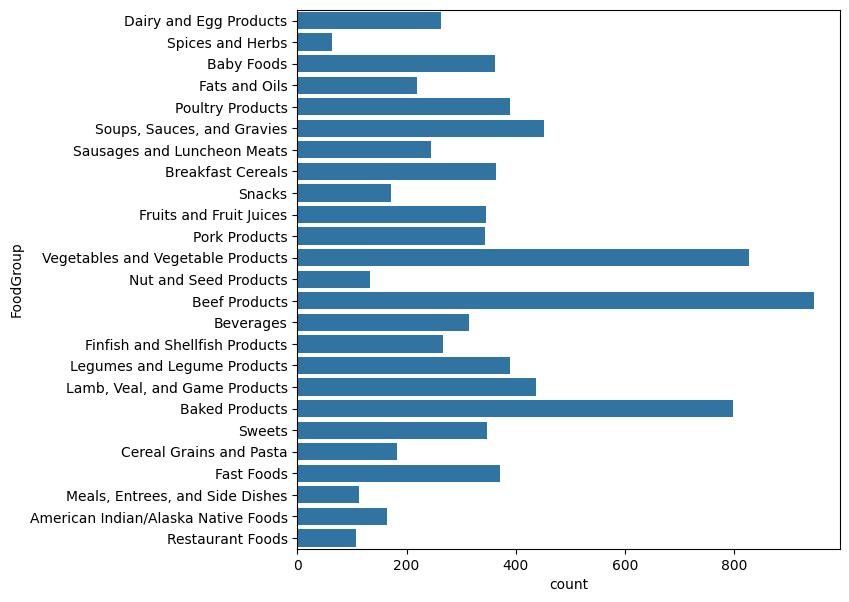

In [8]:
plt.figure(figsize=(7,7))
sns.countplot(df[target]);

*Nos encontramos con el que target está desbalanceado y tenemos 25 posibles clases para predecir. Continuaremos por el momento sin agrupar las clases por grupos alimenticios*

In [9]:
print("Total de clases en 'FoofGruop':", df[target].nunique())
print()
print('Distribución de cada clase:', df[target].value_counts(True))

Total de clases en 'FoofGruop': 25

Distribución de cada clase: FoodGroup
Beef Products                          0.109770
Vegetables and Vegetable Products      0.096078
Baked Products                         0.092481
Soups, Sauces, and Gravies             0.052448
Lamb, Veal, and Game Products          0.050824
Poultry Products                       0.045254
Legumes and Legume Products            0.045138
Fast Foods                             0.043049
Breakfast Cereals                      0.042121
Baby Foods                             0.042005
Sweets                                 0.040265
Fruits and Fruit Juices                0.040149
Pork Products                          0.039800
Beverages                              0.036551
Finfish and Shellfish Products         0.030982
Dairy and Egg Products                 0.030634
Sausages and Luncheon Meats            0.028313
Fats and Oils                          0.025412
Cereal Grains and Pasta                0.021235
Snacks        

### Tratamiento de columnas categóricas

- Tenemos columnas categóricas con un elevado número de missings, como comentamos antes: *'CommonName', 'MfgName', 'ScientificName'* 
- Y columnas cuya cardinalidad es muy elevada: *'ShortDescrip',	'Descrip'*

Excluiremos este listado de columnas ya que no tenemos datos suficientes como para tapar el elevado número de missings y por otro lado, las que presentan alta cardinalidad no aportarán mucha información relevante al modelo.

In [7]:
cat_columns_to_exclude = ['ShortDescrip','Descrip', 'CommonName', 'MfgName', 'ScientificName'] 

In [24]:
tb.describe_df(df[cat_columns_to_exclude])

,COL_N,ShortDescrip,Descrip,CommonName,MfgName,ScientificName
0,DATA_TYPE,object,object,object,object,object
1,MISSINGS (%),0.0,0.0,87.665352,81.898352,91.50615
2,UNIQUE_VALUES,8614,8618,444,93,470
3,CARDIN (%),99.95,100.0,5.14,1.07,5.44


### Tratamiento de columnas numéricas

Vemos la distribución de las columnas numéricas y su correlación

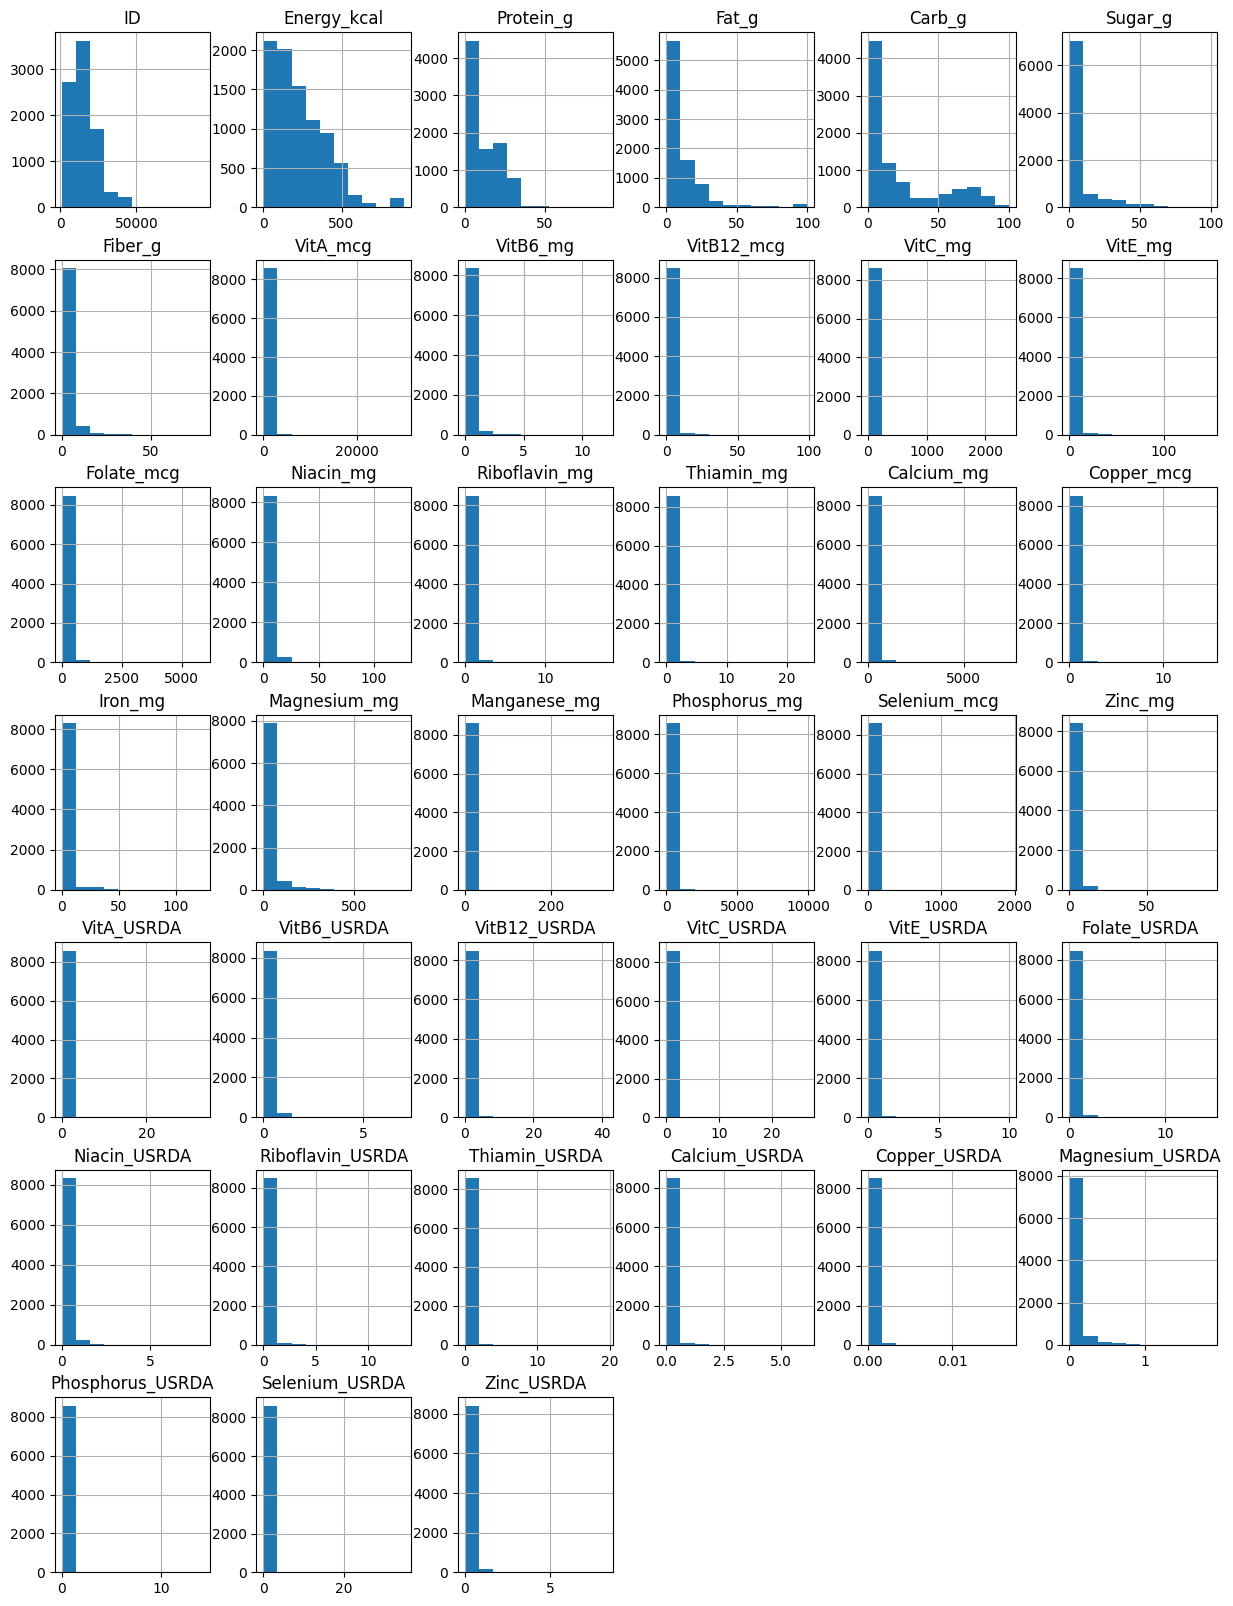

In [12]:
df.hist(figsize=(15,20)); 

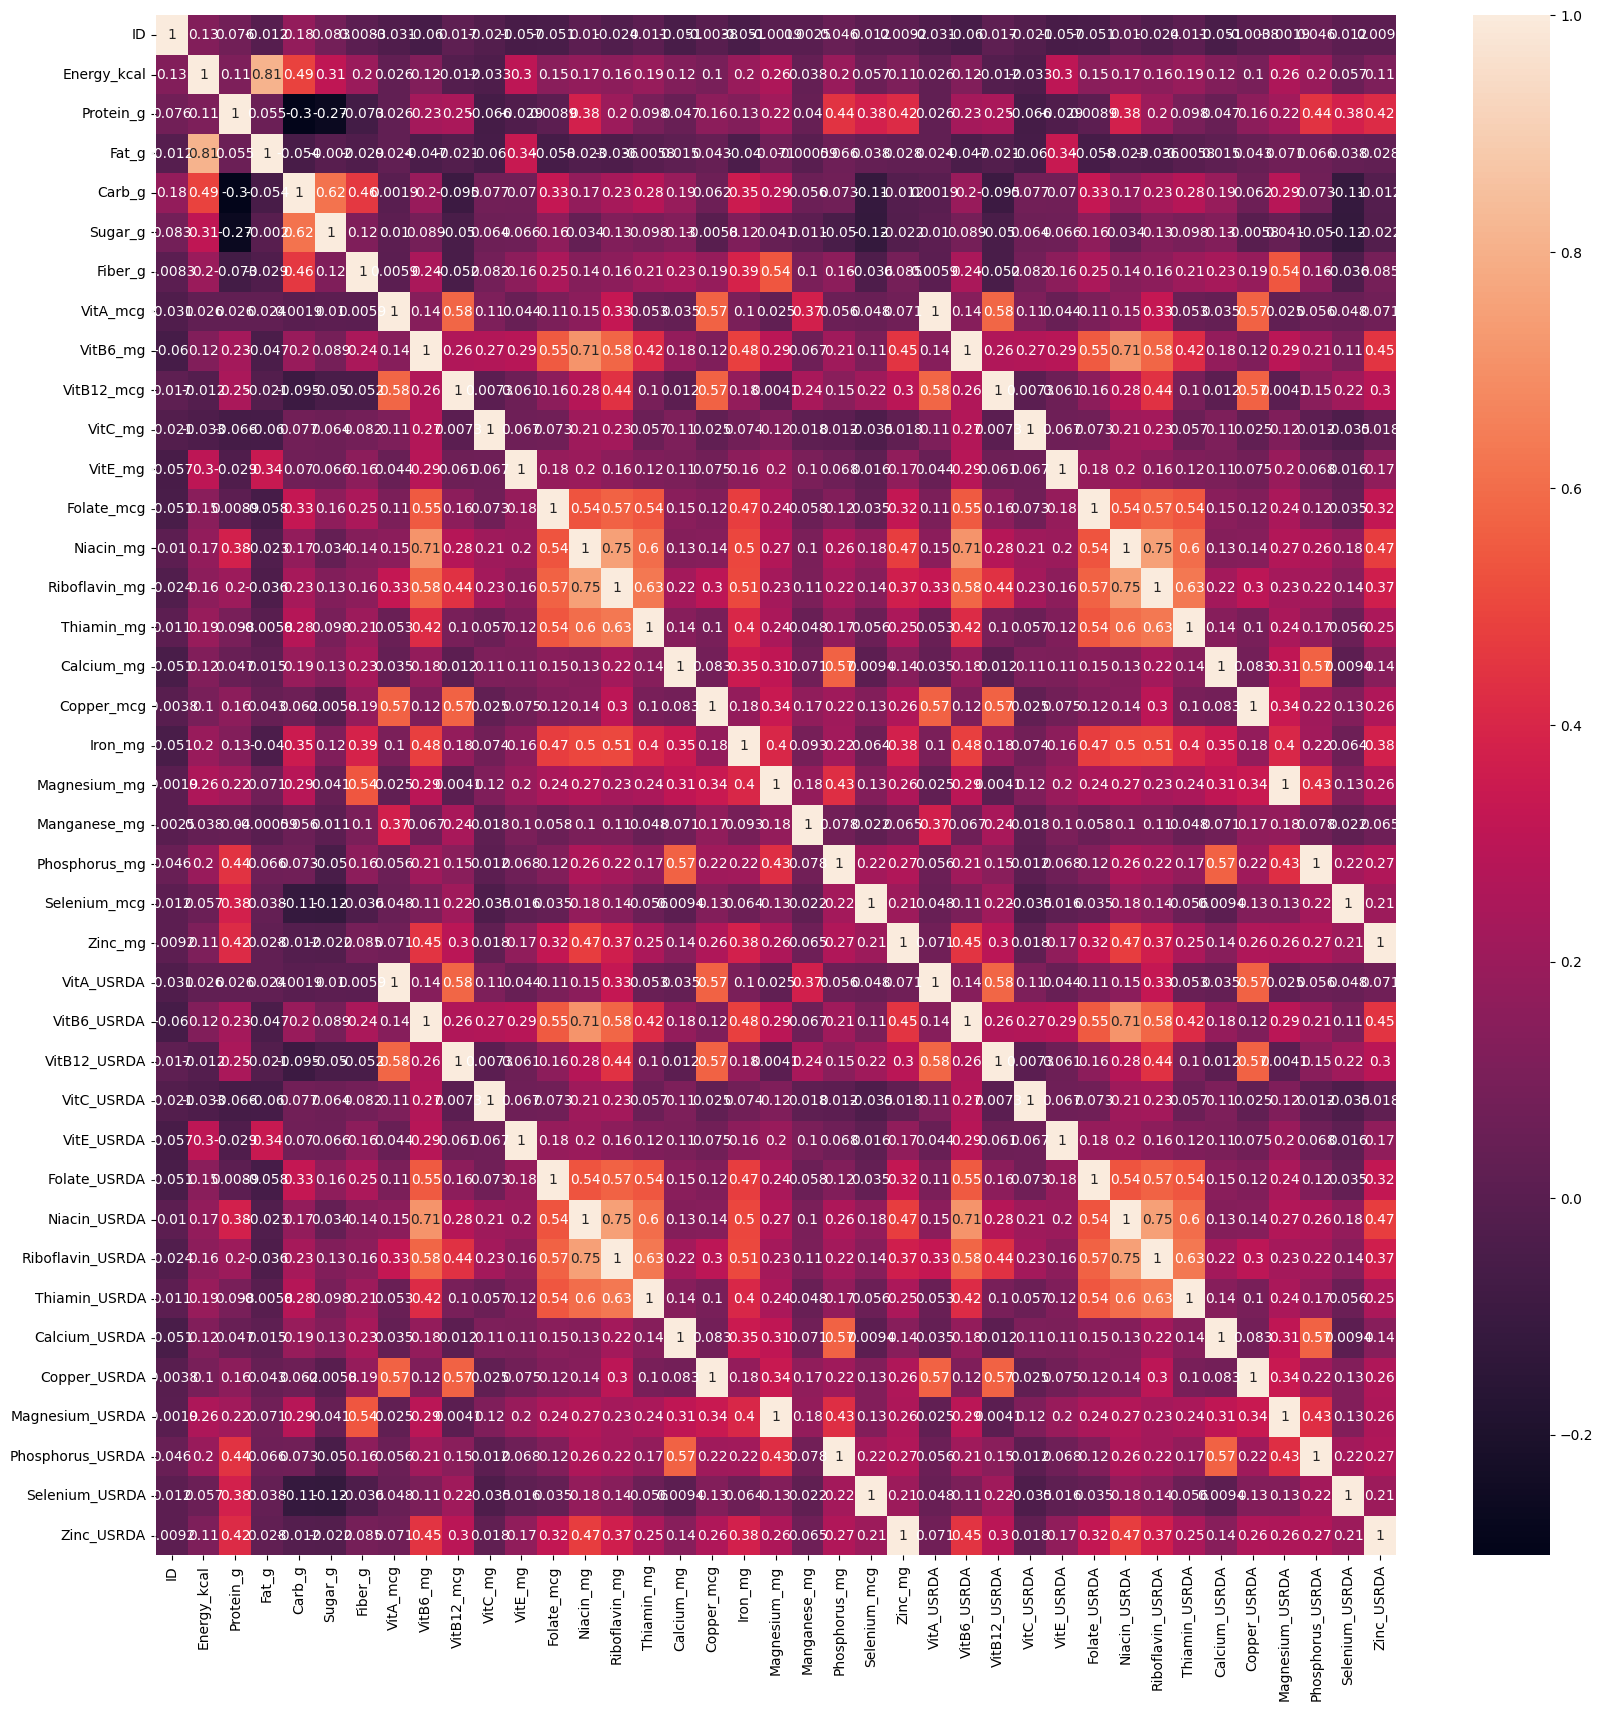

In [13]:
plt.figure(figsize= (20, 20))
sns.heatmap(df.corr(numeric_only= True), annot= True);

Observamos varios puntos a tratar:
- *ID* es una columa con alta cardinalidad, por tanto quedará excluida
- Todas las variables numéricas necesitan una transformación logarítmica.
- Las variables *USRDA* presentan una alta correlación con su pareja en g/mg/mcg. Las excluremos para evitar la multicolinealidad.
- Aplicaremos un StandardScaler ya que nuestros datos están en diferentes escalas (kcal, g, mg, mcg)
- Como reducción y selección de features, aplicaremos una PCA

In [8]:
#seleccionamos las columnas que terminan en _USRDA para excluirlas
num_columns_to_exclude = df.filter(regex='_USRDA$').columns.to_list()
num_columns_to_exclude.append('ID')
num_columns_to_exclude

['VitA_USRDA',
 'VitB6_USRDA',
 'VitB12_USRDA',
 'VitC_USRDA',
 'VitE_USRDA',
 'Folate_USRDA',
 'Niacin_USRDA',
 'Riboflavin_USRDA',
 'Thiamin_USRDA',
 'Calcium_USRDA',
 'Copper_USRDA',
 'Magnesium_USRDA',
 'Phosphorus_USRDA',
 'Selenium_USRDA',
 'Zinc_USRDA',
 'ID']

In [9]:
excluded_cols = num_columns_to_exclude + cat_columns_to_exclude #fusionamos ambas listas de columnas excluidas

In [12]:
#Instanciamos los juegos X,y de train y test para trabajar con ellos los pipelines:
X_train = train_clf.drop(train_clf[[target]], axis=1)
X_test = test_clf.drop(train_clf[[target]], axis=1)

y_train = train_clf[target]
y_test = test_clf[target]

In [58]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6894, 44) (6894,)
(1724, 44) (1724,)


In [13]:
# Lista de variables numericas para tranformar
num_transform = []
for columna in X_train.columns:
    if columna != target and columna not in excluded_cols:
        num_transform.append(columna)

num_transform

['Energy_kcal',
 'Protein_g',
 'Fat_g',
 'Carb_g',
 'Sugar_g',
 'Fiber_g',
 'VitA_mcg',
 'VitB6_mg',
 'VitB12_mcg',
 'VitC_mg',
 'VitE_mg',
 'Folate_mcg',
 'Niacin_mg',
 'Riboflavin_mg',
 'Thiamin_mg',
 'Calcium_mg',
 'Copper_mcg',
 'Iron_mg',
 'Magnesium_mg',
 'Manganese_mg',
 'Phosphorus_mg',
 'Selenium_mcg',
 'Zinc_mg']

## Pipelines

#### Exclusión de columnas, transformación logarítmica y escalado

In [14]:
num_pipeline = Pipeline([
     ('log', FunctionTransformer(np.log1p, feature_names_out='one-to-one')),
    ('SScaler', StandardScaler())
])

# Transformador de columnas
prepocessing = ColumnTransformer([
        ('Impute_Numeric', num_pipeline, num_transform),
        ('Exclude', 'drop', excluded_cols)
    ],
    remainder='passthrough'

)

prepocessing

ColumnTransformer(remainder='passthrough',
                  transformers=[('Impute_Numeric',
                                 Pipeline(steps=[('log',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<ufunc 'log1p'>)),
                                                 ('SScaler',
                                                  StandardScaler())]),
                                 ['Energy_kcal', 'Protein_g', 'Fat_g', 'Carb_g',
                                  'Sugar_g', 'Fiber_g', 'VitA_mcg', 'VitB6_mg',
                                  'VitB12_mcg', 'VitC_mg', 'VitE_mg',
                                  'Folate_mcg', 'Niacin_mg', 'Ribo...
                                  'Phosphorus_mg', 'Selenium_mcg', 'Zinc_mg']),
                                ('Exclude', 'drop',
                                 ['VitA_USRDA', 'VitB6_USRDA', 'VitB12_USRDA',
                                  'VitC_USRDA', 'VitE_USRDA', 'Folate_USRDA',
                                  'Niacin_USRDA', 'Riboflavin_USRDA',
                                  'Thiamin_USRDA', 'Calcium_USRDA',
                                  'Copper_USRDA', 'Magnesium_USRDA',
                                  'Phosphorus_USRDA', 'Selenium_USRDA',
                                  'Zinc_USRDA', 'ID', 'ShortDescrip', 'Descrip',
                                  'CommonName', 'MfgName', 'ScientificName'])])

In [15]:
X_train_pipe = prepocessing.fit_transform(X_train)

In [16]:
X_train_pipe_df = pd.DataFrame(X_train_pipe, columns=prepocessing.get_feature_names_out())
X_train_pipe_df.head()

,Impute_Numeric__Energy_kcal,Impute_Numeric__Protein_g,Impute_Numeric__Fat_g,Impute_Numeric__Carb_g,Impute_Numeric__Sugar_g,Impute_Numeric__Fiber_g,Impute_Numeric__VitA_mcg,Impute_Numeric__VitB6_mg,Impute_Numeric__VitB12_mcg,Impute_Numeric__VitC_mg,...,Impute_Numeric__Riboflavin_mg,Impute_Numeric__Thiamin_mg,Impute_Numeric__Calcium_mg,Impute_Numeric__Copper_mcg,Impute_Numeric__Iron_mg,Impute_Numeric__Magnesium_mg,Impute_Numeric__Manganese_mg,Impute_Numeric__Phosphorus_mg,Impute_Numeric__Selenium_mcg,Impute_Numeric__Zinc_mg
0,-0.209723,-0.359192,-1.501857,0.776741,0.992008,1.794652,1.586607,-0.699123,-0.046257,-0.633938,...,-0.303751,-0.572918,1.232795,-0.490851,-1.323804,-0.394576,-0.477178,0.039575,-0.436508,-0.759357
1,-0.816240,-0.804044,-1.217466,0.380667,0.574640,0.356155,-0.829911,-0.817957,-0.693837,-0.633938,...,-0.843057,-0.702416,-0.206152,-0.645545,-0.682664,-2.183071,-0.477178,-2.492063,-1.180190,-1.149283
2,-0.035818,1.045831,0.154842,-1.312326,-0.795196,-0.815907,-0.829911,-0.346866,0.574040,-0.633938,...,-0.354128,-0.702416,-0.437758,-0.340598,0.256544,-0.252961,-0.397058,0.023985,0.846403,1.200549
3,-0.458709,-0.659057,-0.653007,0.532605,-0.795196,-0.815907,1.090253,-0.678974,-0.348722,-0.212632,...,-0.204593,-0.564122,1.029411,-0.577949,-1.240983,-0.190789,-0.466701,0.098081,-0.389926,-0.726660
4,0.981762,1.110078,1.527686,-1.312326,-0.795196,-0.815907,1.190175,0.230875,0.925953,-0.633938,...,0.145815,-0.498692,-0.796162,-0.355431,0.061395,0.317137,-0.453664,0.689437,0.952977,0.258007


In [63]:
X_train_pipe_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6894 entries, 0 to 6893
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Impute_Numeric__Energy_kcal    6894 non-null   float64
 1   Impute_Numeric__Protein_g      6894 non-null   float64
 2   Impute_Numeric__Fat_g          6894 non-null   float64
 3   Impute_Numeric__Carb_g         6894 non-null   float64
 4   Impute_Numeric__Sugar_g        6894 non-null   float64
 5   Impute_Numeric__Fiber_g        6894 non-null   float64
 6   Impute_Numeric__VitA_mcg       6894 non-null   float64
 7   Impute_Numeric__VitB6_mg       6894 non-null   float64
 8   Impute_Numeric__VitB12_mcg     6894 non-null   float64
 9   Impute_Numeric__VitC_mg        6894 non-null   float64
 10  Impute_Numeric__VitE_mg        6894 non-null   float64
 11  Impute_Numeric__Folate_mcg     6894 non-null   float64
 12  Impute_Numeric__Niacin_mg      6894 non-null   f

#### PCA  
Dado que tenemos 22 features en total, utilizaremos una PCA para reducir la dimensionalidad del set.  
Antes de integrarla en un pipeline, determinaremos cuál es el número de componentes óptimos para alcanzar al menos el 90% de la varianza acumulada.

In [17]:
pca = PCA()
X_train_ncomp_pca = pca.fit(X_train_pipe) #aplicamos la transformacion a todo el dataset

varizanza_acumulada = pca.explained_variance_ratio_.cumsum()
varizanza_acumulada #vemos el total de porcentaje de varianza acumulada por componente

array([0.3107282 , 0.4774828 , 0.56297155, 0.63433414, 0.69389458,
       0.73913455, 0.76872665, 0.79623523, 0.82180403, 0.84469043,
       0.86652842, 0.88574386, 0.90424593, 0.91875139, 0.93232512,
       0.9454359 , 0.95683736, 0.96680202, 0.97629851, 0.98372569,
       0.9905246 , 0.99619686, 1.        ])

En este caso marcaremos un 90% de umbral, esto quiere decir que nos quedaremos con el número de features que expliquen la varianza acumulada del 90%. (Dependiendo de los resultados del modelo podremos subir o bajar el umbral)

In [20]:
umbral = len(varizanza_acumulada[varizanza_acumulada >= 0.90]) #seleccionamos las componentes que acumulan el 90% de varianza 
n_componentes_90 = X_train_pipe.shape[1] - umbral + 1 #Accedemos a las columnas del set de train y restamos el número de componentes que exceden el umbral marcado
                                                            #sumamos 1 porque el indice de columnas comienza en 0 y de esta forma nos dará el número exacto contando desde 1
print(f'Componentes que exceden el 90%: {umbral}')
print(f'El numero de componentes necesarias para alcanzar el {round(varizanza_acumulada[12],2)} es {n_componentes_90}') #Pongo 12 como indice aunque el numero de componentes sea 13 porque en el array empiezo contando desde 0

Componentes que exceden el 90%: 11
El numero de componentes necesarias para alcanzar el 0.9 es 13


Ahora que tenemos el número optimo de componentes, podremos instanciar el pipeline para una PCA con 13 features.

#### **Baseline** usando Cross Validation:

In [ ]:

logreg_pipe = Pipeline(
    [('Preprocesado', prepocessing),
     ('Modelo', LogisticRegression())
     ])

random_pipe = Pipeline(
    [('Preprocesado', prepocessing),
     ('Modelo', RandomForestClassifier())
     ])

dtc_pipe = Pipeline(
    [('Preprocesado', prepocessing),
     ('Modelo', DecisionTreeClassifier())
     ])

knn_pipe = Pipeline([
    ('Preprocesado', prepocessing),
    ('Modelo', KNeighborsClassifier())
    ])

for name,pipe in zip(['logistic_Reg', 'RandomF', 'Decision_tree', 'KNN'], [logreg_pipe, random_pipe, dtc_pipe, knn_pipe]):
    cross_val = np.mean(cross_val_score(pipe, X_train, y_train, cv=10, scoring='balanced_accuracy'))
    print(f'{name} --> {(cross_val):.4f}')

logistic_Reg --> 0.6665
RandomF --> 0.8270
Decision_tree --> 0.6937
KNN --> 0.7516


Dado que el mejor resultado lo hemos obtenido con **RandomForestClassifier**, seleccionaremos este modelo para aplicar la **PCA** y el balanceo del target usando la libreria **imbalanced-learn**

#### Modelado  
Para este pipeline, utilizaremos la librería **imbalanced-learn** ya que queremos aprovechar su método **RandomUnderSampling** para balancear nuestro target.  
 
Nuestro target cuenta con 25 clases distintas, de las cuales la mayoría cuenta con pocas muestras (max. 500). Sólamente tres de las clases cuentan con un mayor número de muestras(más de 900). Por este motivo, se decide realizar un método de Under Sampling, ya que en nuestro caso tendría más sentido reducir las muestras mayoritarias que generear muestras sintéticas para tantas clases, dando lugar así una posible distorsión de la información. 

In [ ]:
#instanciamos el pipeline para el modelo
model_pipe = ImbPipeline(steps=[
    ('Preprocesado', prepocessing),
    ('undersampler', RandomUnderSampler(random_state=42)),
    ('pca', PCA(n_components=13)),
    ('Modelo', RandomForestClassifier())     
])

#### Optimización de hiperparámetros con **RandomizedSearchCV** vs. **GridSearchCV**

In [63]:
param_random = {
    'Modelo__n_estimators': [100, 200],
    'Modelo__max_depth': [10, 20],
    'Modelo__min_samples_split': [2, 5, 10],
    'Modelo__min_samples_leaf': [1, 2, 4],
}

#Pruebo con RandomizedSearch: n_iter indica el numero de hiperparametros que se probarán aleatoriamente
random_search = RandomizedSearchCV(model_pipe, n_iter=50, param_distributions=param_random, scoring='balanced_accuracy', cv=10, n_jobs=-1)

random_search.fit(X_train, y_train)


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('Preprocesado',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('Impute_Numeric',
                                                                               Pipeline(steps=[('log',
                                                                                                FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                    func=<ufunc 'log1p'>)),
                                                                                               ('SScaler',
                                                                                                StandardScaler())]),
                                                                               ['Energy_kcal',
                                                                                'Protein_g',
                                                                                'Fat_g',
                                                                                'Carb_g',
                                                                                'Sugar_g',
                                                                                'Fiber_g',
                                                                                'VitA_mcg',
                                                                                'VitB6_...
                                                                                'MfgName',
                                                                                'ScientificName'])])),
                                             ('undersampler',
                                              RandomUnderSampler(random_state=42)),
                                             ('pca', PCA(n_components=13)),
                                             ('Modelo',
                                              RandomForestClassifier())]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'Modelo__max_depth': [10, 20],
                                        'Modelo__min_samples_leaf': [1, 2, 4],
                                        'Modelo__min_samples_split': [2, 5, 10],
                                        'Modelo__n_estimators': [100, 200]},
                   scoring='balanced_accuracy')

In [64]:
print('Mejores parámetros:', random_search.best_params_)
print('Mejor score:', random_search.best_score_)

Mejores parámetros: {'Modelo__n_estimators': 200, 'Modelo__min_samples_split': 2, 'Modelo__min_samples_leaf': 1, 'Modelo__max_depth': 20}
Mejor score: 0.6893655388110551


Frente al baseline lo hace bastante peor. Probamos con **GridSearchCV**

In [65]:
param_grid = {
    'Modelo__n_estimators': [100, 200],
    'Modelo__max_depth': [10, 20],
    'Modelo__min_samples_split': [2, 5, 10],
    'Modelo__min_samples_leaf': [1, 2, 4],
}

#Pruebo con RandomizedSearch: n_iter indica el numero de hiperparametros que se probarán aleatoriamente
grid_search = GridSearchCV(model_pipe, param_grid, scoring='balanced_accuracy', cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Preprocesado',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('Impute_Numeric',
                                                                         Pipeline(steps=[('log',
                                                                                          FunctionTransformer(feature_names_out='one-to-one',
                                                                                                              func=<ufunc 'log1p'>)),
                                                                                         ('SScaler',
                                                                                          StandardScaler())]),
                                                                         ['Energy_kcal',
                                                                          'Protein_g',
                                                                          'Fat_g',
                                                                          'Carb_g',
                                                                          'Sugar_g',
                                                                          'Fiber_g',
                                                                          'VitA_mcg',
                                                                          'VitB6_mg',
                                                                          'Vi...
                                                                          'Descrip',
                                                                          'CommonName',
                                                                          'MfgName',
                                                                          'ScientificName'])])),
                                       ('undersampler',
                                        RandomUnderSampler(random_state=42)),
                                       ('pca', PCA(n_components=13)),
                                       ('Modelo', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'Modelo__max_depth': [10, 20],
                         'Modelo__min_samples_leaf': [1, 2, 4],
                         'Modelo__min_samples_split': [2, 5, 10],
                         'Modelo__n_estimators': [100, 200]},
             scoring='balanced_accuracy')

In [66]:
print('Mejores parámetros:', grid_search.best_params_)
print('Mejor score:', grid_search.best_score_)

Mejores parámetros: {'Modelo__max_depth': 20, 'Modelo__min_samples_leaf': 1, 'Modelo__min_samples_split': 2, 'Modelo__n_estimators': 100}
Mejor score: 0.6780849319405047


Da mejor resultado, probamos para ver si podemos mejorarlo un poco más a pasar un pipeline sin métodos de muestreo para el target y ponerlos como hiperparámetros del grid

In [ ]:
#instanciamos el pipeline para el modelo
model_pipe_bis = ImbPipeline(steps=[
    ('Preprocesado', prepocessing),
    ('muestreo', None), #None para poder añadir diferentes opciones de hiperparametros en el Grid a posteriori
    ('pca', PCA(n_components=13)),
    ('Modelo', RandomForestClassifier()) 
    ])

In [68]:
param_grid_bis = {
    'muestreo' : [RandomUnderSampler(random_state=42), RandomOverSampler(random_state=42)],
    'Modelo__n_estimators': [100, 200],
    'Modelo__max_depth': [10, 20],
    'Modelo__min_samples_split': [2, 5, 10],
    'Modelo__min_samples_leaf': [1, 2, 4],
}

#Pruebo con RandomizedSearch: n_iter indica el numero de hiperparametros que se probarán aleatoriamente
grid_search_bis = GridSearchCV(model_pipe_bis, param_grid_bis, scoring='balanced_accuracy', cv=5, n_jobs=-1)

grid_search_bis.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Preprocesado',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('Impute_Numeric',
                                                                         Pipeline(steps=[('log',
                                                                                          FunctionTransformer(feature_names_out='one-to-one',
                                                                                                              func=<ufunc 'log1p'>)),
                                                                                         ('SScaler',
                                                                                          StandardScaler())]),
                                                                         ['Energy_kcal',
                                                                          'Protein_g',
                                                                          'Fat_g',
                                                                          'Carb_g',
                                                                          'Sugar_g',
                                                                          'Fiber_g',
                                                                          'VitA_mcg',
                                                                          'VitB6_mg',
                                                                          'Vi...
                                       ('muestreo', None),
                                       ('pca', PCA(n_components=13)),
                                       ('Modelo', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'Modelo__max_depth': [10, 20],
                         'Modelo__min_samples_leaf': [1, 2, 4],
                         'Modelo__min_samples_split': [2, 5, 10],
                         'Modelo__n_estimators': [100, 200],
                         'muestreo': [RandomUnderSampler(random_state=42),
                                      RandomOverSampler(random_state=42)]},
             scoring='balanced_accuracy')

In [69]:
print('Mejores parámetros:', grid_search_bis.best_params_)
print('Mejor score:', grid_search_bis.best_score_)

Mejores parámetros: {'Modelo__max_depth': 20, 'Modelo__min_samples_leaf': 1, 'Modelo__min_samples_split': 5, 'Modelo__n_estimators': 200, 'muestreo': RandomOverSampler(random_state=42)}
Mejor score: 0.7616818155090535


In [74]:
with open('Modelo_gridsearch_bis', 'wb') as file:
    pickle.dump(grid_search_bis, file)

Hemos conseguido que mejore al 76% de accuracy en este caso, ha sido mejor emplear RandomOverSampler como técnica de muestreo para las clases minoritarias.

#### Evaluación

In [71]:
y_pred = grid_search_bis.predict(X_test)
prediccion = balanced_accuracy_score(y_test, y_pred)
test_score = classification_report(y_test, y_pred)

In [75]:
print(test_score)

                                     precision    recall  f1-score   support

American Indian/Alaska Native Foods       0.62      0.39      0.48        33
                         Baby Foods       0.90      0.83      0.86        72
                     Baked Products       0.85      0.90      0.87       159
                      Beef Products       0.97      0.95      0.96       189
                          Beverages       0.86      0.70      0.77        63
                  Breakfast Cereals       0.84      0.86      0.85        73
            Cereal Grains and Pasta       0.68      0.86      0.76        37
             Dairy and Egg Products       0.87      0.89      0.88        53
                         Fast Foods       0.82      0.85      0.83        74
                      Fats and Oils       0.81      0.77      0.79        44
     Finfish and Shellfish Products       0.85      0.89      0.87        53
            Fruits and Fruit Juices       0.76      0.83      0.79        6

In [83]:
resultados = pd.DataFrame({'Train_score': round(grid_search_bis.best_score_,2),
                           'Test_score' : prediccion}, index=['RandomForestClsf'])

resultados

,Train_score,Test_score
RandomForestClsf,0.76,0.796336


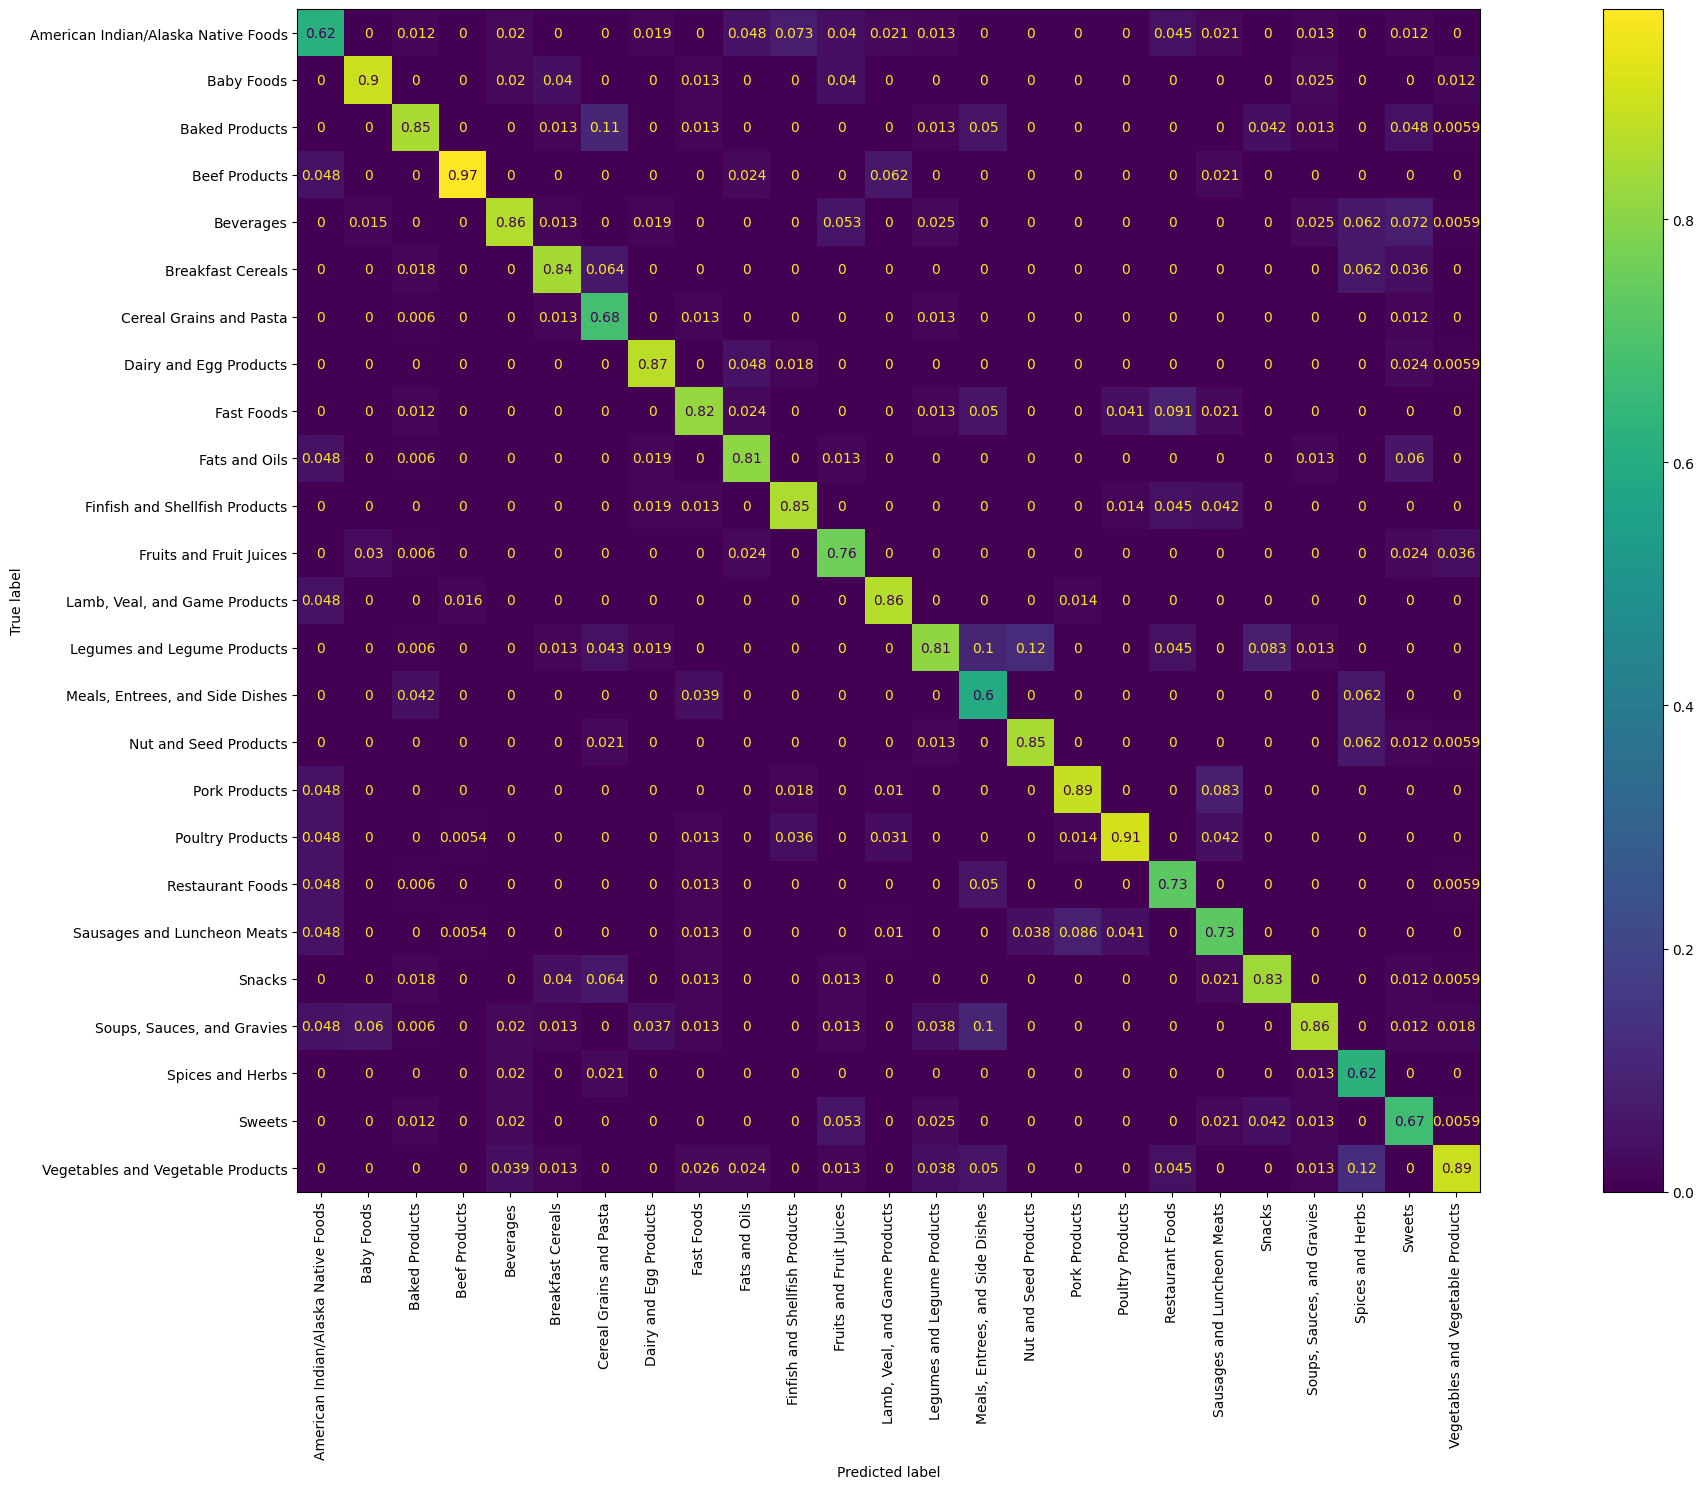

In [100]:
fig, ax = plt.subplots(figsize=(25,15))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize= "pred", ax=ax)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()